# Лабораторная работа №5

|Выполнил студент группы|ФИО|Вариант|
|--|--|--|
|М8О-406Б-19|Илья Ильин Олегович|1|

### Задание

Используя явную и неявную конечно-разностные схемы, а также схему Кранка -
Николсона, решить начально-краевую задачу для дифференциального уравнения
параболического типа. Осуществить реализацию трех вариантов аппроксимации
граничных условий, содержащих производные: двухточечная аппроксимация с
первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная
аппроксимация со вторым порядком. 

В различные моменты времени вычислить
погрешность численного решения путем сравнения результатов с приведенным в
задании аналитическим решением
$U(x,t)$
. Исследовать зависимость погрешности от
сеточных параметров
$ \tau, h$ .

### Вариант

$\frac{\partial u}{\partial t} = a \frac{\partial u^2}{\partial x^2}, a>0$

$u(0, t) = \phi_0(t) = 0$

$u(\pi, t) = \phi_l(t)= 1$

$u(x, 0) = x + sin(\pi x)$

Аналитическое решение: 
$U(x,t) = x + exp(-\pi^2 at)sin(\pi x)$


In [10]:
import numpy as np
from typing import List, Callable
import matplotlib.pyplot as plt
from matplotlib import cm

In [11]:
def second_derivative(values: np.ndarray, step: float):
    derivatives = np.zeros(shape=values.shape)
    for i in range(1, len(values) - 1):
        derivatives[i] = (values[i - 1] - 2.0 * values[i] + values[i + 1]) / step**2
    return derivatives

In [12]:
def sweep_solve(matrix: np.ndarray, target: np.ndarray) -> np.ndarray:
    p_coeffs: np.ndarray = np.zeros(shape=matrix.shape[1])
    q_coeffs: np.ndarray = np.zeros(shape=matrix.shape[1])

    for i in range(matrix.shape[1]):
        if i == matrix.shape[1] - 1:
            p_coeffs[i] = 0
        elif i == 0:
            p_coeffs[i] = -matrix[i, i + 1] / matrix[i, i]
        else:
            p_coeffs[i] = -matrix[i, i + 1] / (matrix[i, i] + matrix[i, i - 1] * p_coeffs[i - 1])

        if i == 0:
            q_coeffs[i] = target[i] / matrix[i, i]
        else:
            q_coeffs[i] = ((target[i] - matrix[i, i - 1] * q_coeffs[i - 1]) /
                           (matrix[i, i] + matrix[i, i - 1] * p_coeffs[i - 1]))

    answer: np.ndarray = np.zeros(shape=matrix.shape[1] + 1)

    for i in range(matrix.shape[1] - 1, -1, -1):
        answer[i] = p_coeffs[i] * answer[i + 1] + q_coeffs[i]

    return answer[:-1]

In [13]:
def explicit_method(u_initial: Callable, u_left_border: Callable, u_right_border: Callable,
                    a: float, h: float, tau: float,
                    l: float, r: float, t_bound: float) -> np.ndarray:
    if a * tau / h**2 > 0.5:
        print("WARNING : explicit method is not stable")

    x: np.ndarray = np.arange(l, r + h/2.0, step=h)
    t: np.ndarray = np.arange(0, t_bound + tau/2.0, step=tau)
    u: np.ndarray = np.zeros(shape=(len(t), len(x)))

    u[0] = u_initial(x)
    u[0, 0] = u_left_border()
    u[0, -1] = u_right_border()

    for k in range(len(t) - 1):
        u[k+1] = u[k] + tau * a * second_derivative(u[k], step=h)

    return u


def hybrid_method(u_initial: Callable, u_left_border: Callable, u_right_border: Callable,
                  a: float, h: float, tau: float,
                  l: float, r: float, t_bound: float, theta: float) -> np.ndarray:
    x: np.ndarray = np.arange(l, r + h/2.0, step=h)
    t: np.ndarray = np.arange(0, t_bound + tau/2.0, step=tau)
    u: np.ndarray = np.zeros(shape=(len(t), len(x)))

    u[0] = u_initial(x)
    u[0, 0] = u_left_border()
    u[0, -1] = u_right_border()

    for k in range(len(t) - 1):
        matrix: np.ndarray = np.zeros(shape=(len(x) - 2, len(x) - 2))
        matrix[0] += np.array(
            [
                -(1.0 + (2.0 * theta * a * tau) / h**2),
                (theta * a * tau) / h**2
            ]
            + [0.0] * (len(matrix) - 2)
        )
        target: List[float] = [(theta - 1.0) * a * tau * u[k][0] / h**2 +
                               (2.0 * (1.0 - theta) * a * tau / h**2 - 1.0) * u[k][1] +
                               (theta - 1.0) * a * tau * u[k][2] / h**2 -
                               theta * a * tau * u_left_border() / h**2]

        for i in range(1, len(matrix) - 1):
            matrix[i] += np.array(
                [0.0] * (i - 1)
                + [
                    theta * a * tau / h**2,
                    -(1.0 + (2.0 * theta * a * tau) / h**2),
                    (theta * a * tau) / h**2
                ]
                + [0.0] * (len(matrix) - i - 2)
            )
            target += [(theta - 1.0) * a * tau * u[k][i] / h**2 +
                       (2.0 * (1.0 - theta) * a * tau / h**2 - 1.0) * u[k][i+1] +
                       (theta - 1.0) * a * tau * u[k][i+2] / h**2]

        matrix[-1] += np.array(
            [0.0] * (len(matrix) - 2)
            + [
                theta * a * tau / h ** 2,
                -(1.0 + (2.0 * theta * a * tau) / h ** 2)
            ]
        )
        target += [(theta - 1.0) * a * tau * u[k][-3] / h**2 +
                   (2.0 * (1.0 - theta) * a * tau / h**2 - 1.0) * u[k][-2] +
                   (theta - 1.0) * a * tau * u[k][-1] / h**2 -
                   theta * a * tau * u_right_border() / h**2]

        u[k+1] += np.array([u_left_border()]
                           + sweep_solve(matrix, np.array(target)).tolist()
                           + [u_right_border()])

    return u


def implicit_method(**kwargs) -> np.ndarray:
    return hybrid_method(**kwargs, theta=1.0)


def crank_nicolson_method(**kwargs) -> np.ndarray:
    return hybrid_method(**kwargs, theta=0.5)

In [14]:
def analytical_solution(a: float, x: float, t: float) -> float:
    assert(a > 0.0)
    return x + np.exp(-np.pi**2 * a * t) * np.sin(np.pi * x)


def analytical_grid(a: float, x: np.ndarray, t: np.ndarray) -> np.ndarray:
    grid: np.ndarray = np.zeros(shape=(len(t), len(x)))
    for i in range(len(t)):
        for j in range(len(x)):
            grid[i, j] = analytical_solution(a, x[j], t[i])
    return grid


def u_initial(x: np.ndarray) -> np.ndarray:
    return x + np.sin(np.pi * x)


def u_left_border():
    return 0.0


def u_right_border():
    return 1.0


def error(numeric: np.ndarray, analytical: np.ndarray) -> np.ndarray:
    return np.max(np.abs(numeric - analytical), axis=1)



In [15]:
def draw(numerical: np.ndarray, analytical: np.ndarray,
         x: np.ndarray, t: np.ndarray):

    fig = plt.figure(figsize=plt.figaspect(0.7))
    xx, tt = np.meshgrid(x, t)

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    plt.title('numerical')
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('t', fontsize=20)
    ax.set_zlabel('u', fontsize=20)
    ax.plot_surface(xx, tt, numerical, cmap=cm.coolwarm, linewidth=0, antialiased=True)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('t', fontsize=20)
    ax.set_zlabel('u', fontsize=20)
    plt.title('analytic')
    ax.plot_surface(xx, tt, analytical, cmap=cm.coolwarm, linewidth=0, antialiased=True)

    plt.show()

    plt.scatter(xx[0], analytical[0], c='blue')
    plt.plot(xx[0], numerical[0], c='blue')
    plt.scatter(xx[3], analytical[3], c='orange')
    plt.plot(xx[3], numerical[3], c='orange')
    plt.scatter(xx[5], analytical[5], c='red')
    plt.plot(xx[5], numerical[5], c='red')
    plt.show()
    
    # print(analytical[0].shape)
#     drawerror(error(numerical[-1], analytical[-1]))

def drawerror(error):
     plt.plot(np.arange(0, error.shape[0]), error)
     plt.title('Error')
     plt.xlabel('t')
     plt.ylabel('error')
     plt.show()


In [20]:
def runner(a, h, tau, t_bound):

    x: np.ndarray = np.arange(0, 1.0 + h/2.0, step=h)
    t: np.ndarray = np.arange(0, t_bound + tau/2.0, step=tau)

    kwargs = {
        "u_initial": u_initial,
        "u_left_border": u_left_border,
        "u_right_border": u_right_border,
        "a": a,
        "h": h,
        "tau": tau,
        "l": 0.0,
        "r": 1.0,
        "t_bound": t_bound
    }

    analytical = analytical_grid(a, x, t)

    print("---------------- EXPLICIT ----------------")
    sol = explicit_method(**kwargs)
    draw(sol, analytical, x, t)
    drawerror(error(sol, analytical))
    print("------------------------------------------\n")
    print("---------------- IMPLICIT ----------------")
    sol = implicit_method(**kwargs)
    draw(sol, analytical, x, t)
    drawerror(error(sol, analytical))
    print("------------------------------------------\n")
    print("------------- CRANK-NICOLSON -------------")
    sol = crank_nicolson_method(**kwargs)
    draw(sol, analytical, x, t)
    drawerror(error(sol, analytical))
    print("------------------------------------------\n")
    print(error(sol, analytical).shape)
    print(sol.shape)
    

---------------- EXPLICIT ----------------


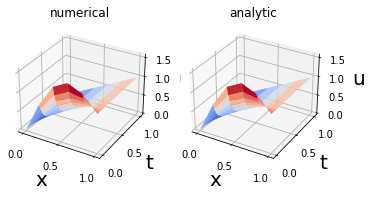

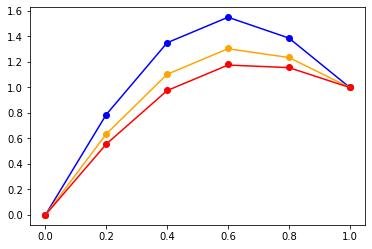

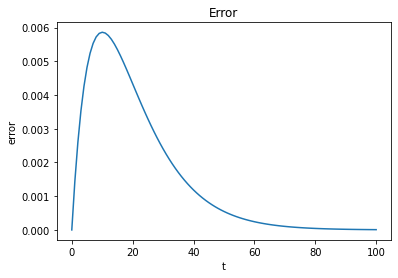

------------------------------------------

---------------- IMPLICIT ----------------


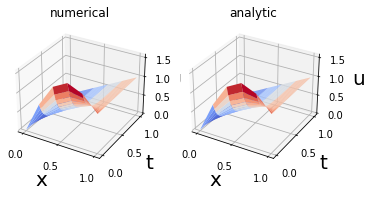

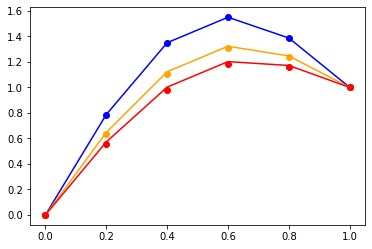

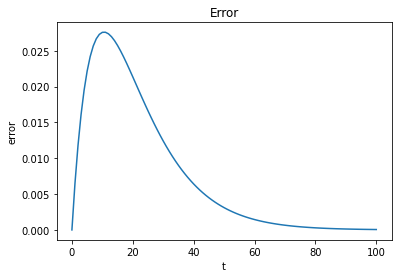

------------------------------------------

------------- CRANK-NICOLSON -------------


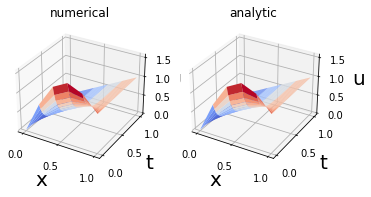

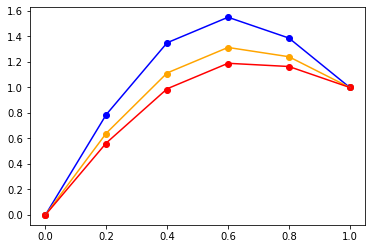

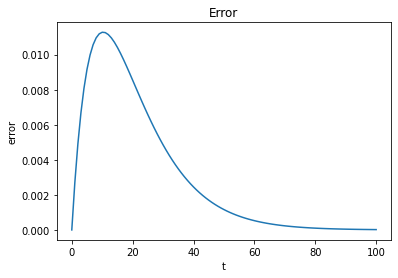

------------------------------------------

(101,)
(101, 6)


In [21]:
testcase_1 = {'a': 1.0,
                'h' : 0.2,
                'tau' : 0.01,
                't_bound' : 1}
runner(**testcase_1)